In [122]:
from fbprophet import Prophet
import matplotlib as plt 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import datetime
from pmdarima.arima import auto_arima
import pickle 
#remove error : TypeError: float() argument must be a string or a number, not 'Period'
pd.plotting.register_matplotlib_converters()


In [2]:
plt.rcParams['font.sans-serif'] = "Georgia"

In [3]:
df = pd.read_csv('new_york.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True)

#change to EST 
df['Date'] = df['Date'].dt.tz_convert('US/Eastern')

df.index = df.Date
#df = df.drop('Date', axis=1)
df = df[df['Consumption'] != 0]



__Resample Daily and Plot__

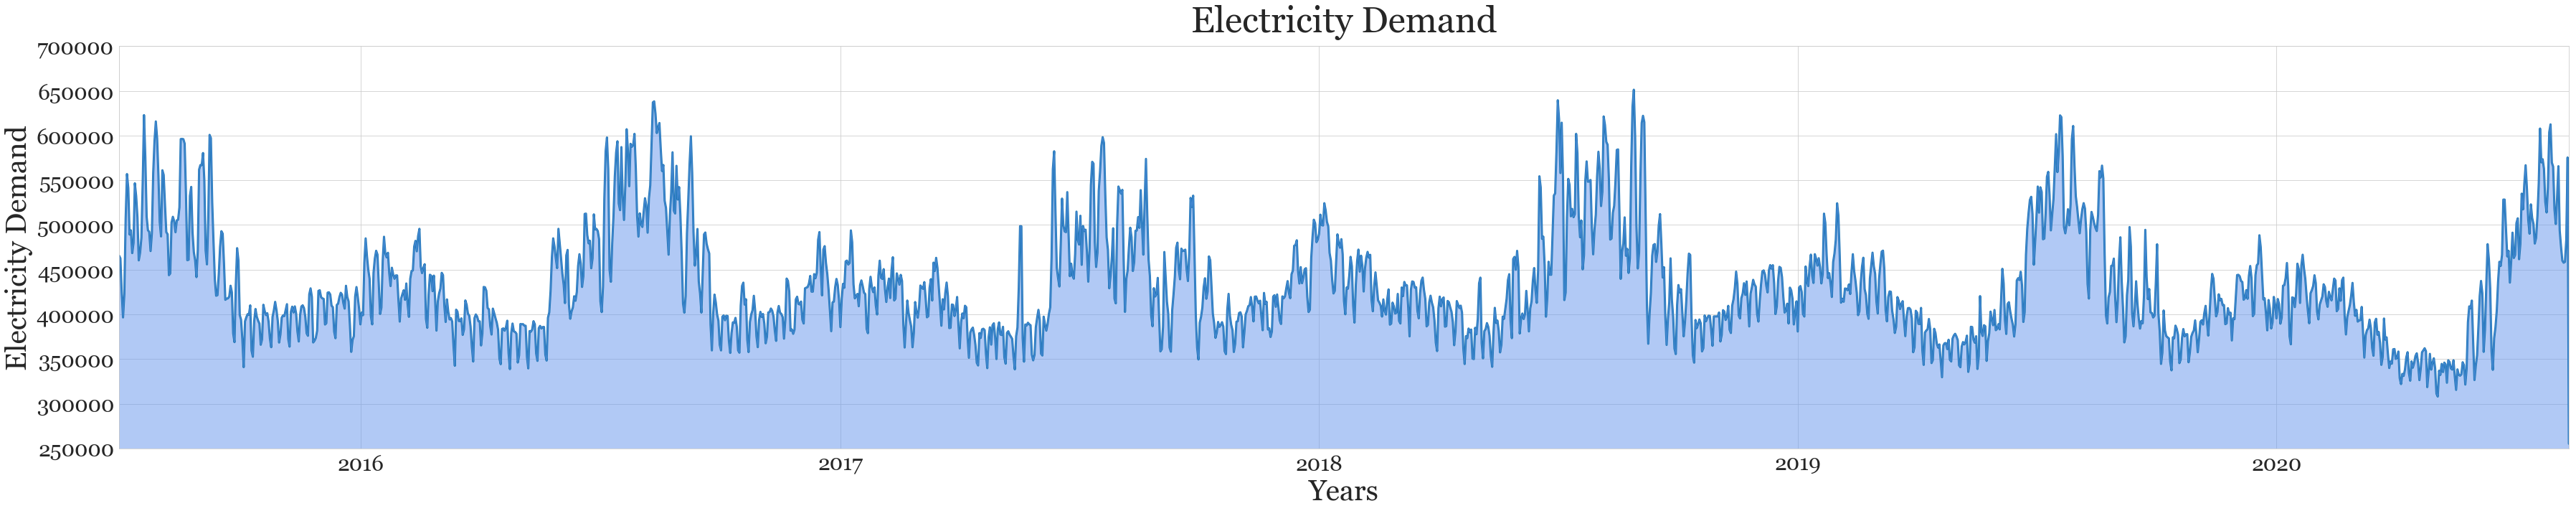

In [4]:
#resample daily and plot

ax = df.resample('D').sum().plot(figsize = (50,10), linewidth=3, legend=False)
df.resample('D').sum().plot.area(alpha=0.5, color ='cornflowerblue',ax =ax, legend =False)
ax.set_ylim([250000,700000])
plt.title('Electricity Demand', fontsize=50, pad=20)
plt.xlabel('Years',fontsize=40)
plt.ylabel('Electricity Demand', fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Electricity Demand',fontsize=40)
plt.tight_layout()

In [5]:
def season_calc(month):
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"


weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}


df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['hour'] = df.Date.dt.hour
df['weekday'] = df.Date.dt.weekday.map(weekdays)
df['season'] = df.Date.dt.month.apply(season_calc)

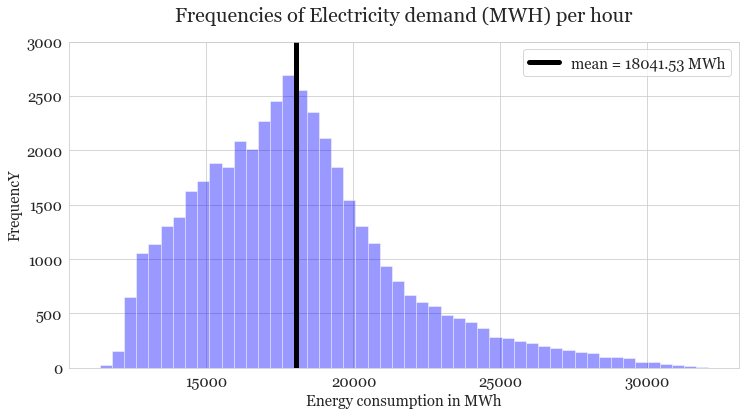

In [6]:
#overall distribution of energy consumption 

plt.figure(figsize = (12,6))
sns.distplot(df['Consumption'], kde=False, color='blue')
plt.axvline(x=df['Consumption'].mean(), c = 'black', linewidth = 5, label = f'mean = {df.Consumption.mean():.2f} MWh')
plt.title('Frequencies of Electricity demand (MWH) per hour', fontsize=20, pad=20)
plt.xlabel('Energy consumption in MWh', fontsize=15)
plt.ylabel('FrequencY', fontsize=15)
plt.ylim([0,3000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)


In [7]:
yearly = df.groupby(['year'])['Consumption'].agg('sum').reset_index()
yearly['Consumption'] =yearly['Consumption']/1_000_000
yearly

year  Consumption
0  2015    82.442169
1  2016   160.798266
2  2017   156.324631
3  2018   161.119320
4  2019   155.817441
5  2020    92.462159

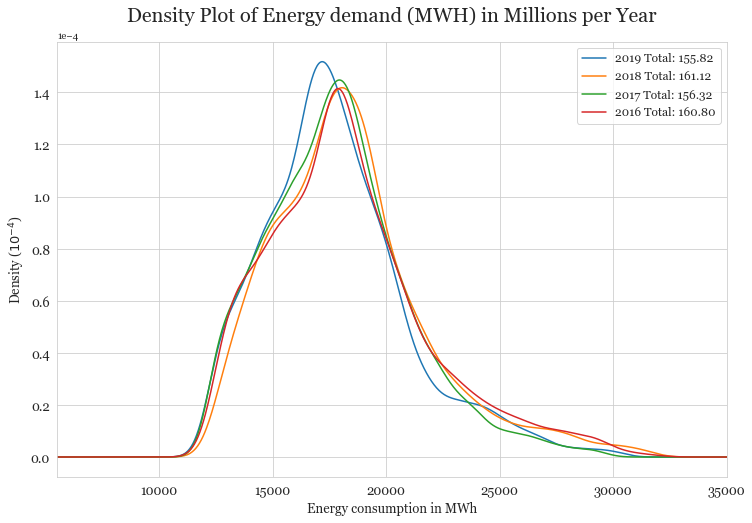

In [8]:
for year in df['year'].unique():
    if year != 2020 and year != 2015:
   
        consumption = yearly.loc[yearly['year'] == year].Consumption.values[0]
        
        df[df['year'] == year]['Consumption'].plot(kind='density', figsize = (12,8), 
                                                   legend = True, label = str(year) + ' Total: ' + f'{consumption:.2f}')


plt.title('Density Plot of Energy demand (MWH) in Millions per Year', fontsize=20, pad=20)
plt.xlim([5500,35000])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Energy consumption in MWh', fontsize=13)
plt.ylabel(r'Density ($10^{-4}$)', fontsize=13)
plt.legend(fontsize=12)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,2))

Text(0.5, 33.0, 'Year')

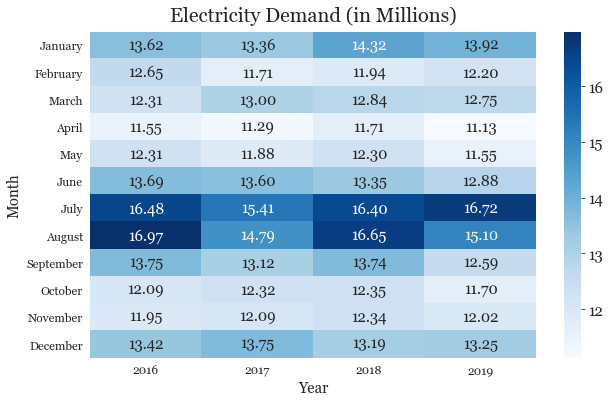

In [9]:

df1 = df.copy() 
df1["Year"] = df1.Date.apply(lambda x: x.year)

#due to incomplete data for these dates
df1 = df1[(df1["Year"]!=2015) & (df1["Year"]!=2020) ]

df1["Month"] = df1.Date.apply(lambda x: x.strftime("%B"))
pt = df1.pivot_table(index="Month",columns="Year",values="Consumption", aggfunc="sum").fillna(0)
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
pt = pt.reindex_axis(months)
pt = pt/1_000_000

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title(f'Electricity Demand (in Millions)', fontsize = 20,pad = 10)
sns.heatmap(pt,cmap="Blues", xticklabels=True, yticklabels=True, annot=True, fmt='.2f', annot_kws={"size": 15})

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

ax.tick_params(labelsize=12)

ax.set_ylabel('Month', fontsize=15)
ax.set_xlabel('Year', fontsize=15)


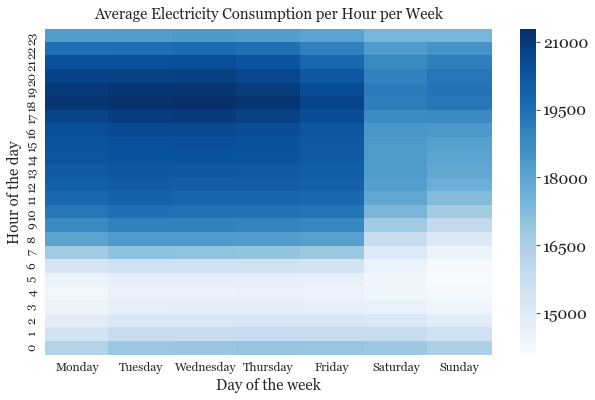

In [10]:

hour_weekday = df.pivot_table(values='Consumption', index='hour', columns = 'weekday', aggfunc = 'mean')
hour_weekday = hour_weekday[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap="Blues")
ax.set_title("Average Electricity Consumption per Hour per Week", fontsize = 15, pad = 10)
ax.tick_params(labelsize=12)
ax.set_ylabel('Hour of the day', fontsize=15)
ax.set_xlabel('Day of the week', fontsize=15)

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)


In [11]:
#weekdays vs non-working
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

#adding holidays

#Adding holidays column to indicate whether a day was a holiday as per the US calendar or not
cal = calendar()
holidays = cal.holidays(start = df['Date'].min(), end = df['Date'].max())
df['holiday'] = df['Date'].isin(holidays)

#adding in another column which indicates 'non-working' days which include weekends and holidays
df['non_working'] = df.apply(lambda x: 'non-working' if \
                                         ((x['holiday'] == 1) or (x['weekday'] in ['Saturday', 'Sunday']))
                                         else 'working', axis = 1)



In [12]:
df.columns

Index(['Date', 'Consumption', 'year', 'month', 'day', 'hour', 'weekday',
       'season', 'holiday', 'non_working'],
      dtype='object')

In [13]:
df.groupby(['non_working'])['Consumption'].agg('sum')

non_working
non-working    218699314
working        590264672
Name: Consumption, dtype: int64

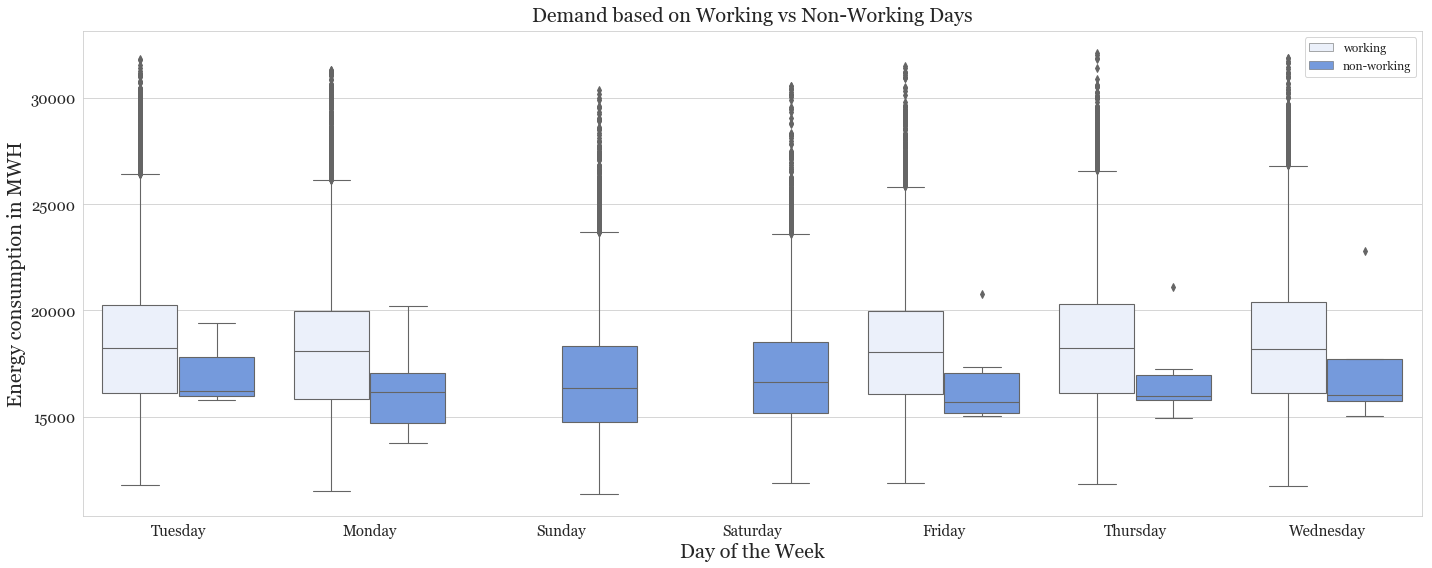

In [14]:
plt.figure(figsize = (20,8))
sns.boxplot(x = 'weekday', y = 'Consumption', data = df, color='cornflowerblue', hue='non_working', linewidth=1.1)
plt.ylabel('Energy consumption in MWH',fontsize=20)
plt.xlabel('Day of the Week',fontsize=20)
plt.title('Demand based on Working vs Non-Working Days', fontsize = 20,pad = 10)
plt.tick_params(labelsize=15)
plt.legend(fontsize=12)

plt.tight_layout()

In [15]:
#PLotting for seasons

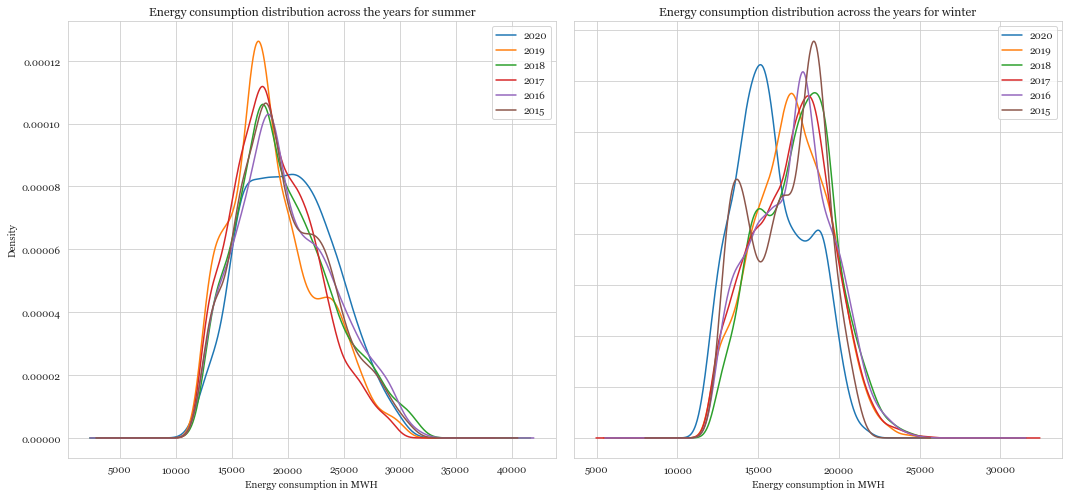

In [16]:
season = ['summer', 'winter']
#color_names = ["tab:blue", "tab:orange", "tab:green", "tab:red" , "tab:purple"]
for i, season in enumerate(season):
    ax = plt.subplot(121+i)
    for j, year in enumerate(df['year'].unique()):

        df[(df['year'] == year) & (df['season'] == season)]['Consumption'].\
                                plot(kind='density', figsize=(15,7), legend=True, label= year, sharey=True)#, \
                                #c = color_names[j])
    plt.title('Energy consumption distribution across the years for '+season)
    plt.xlabel('Energy consumption in MWH')

plt.tight_layout()

#would be different for other data sources

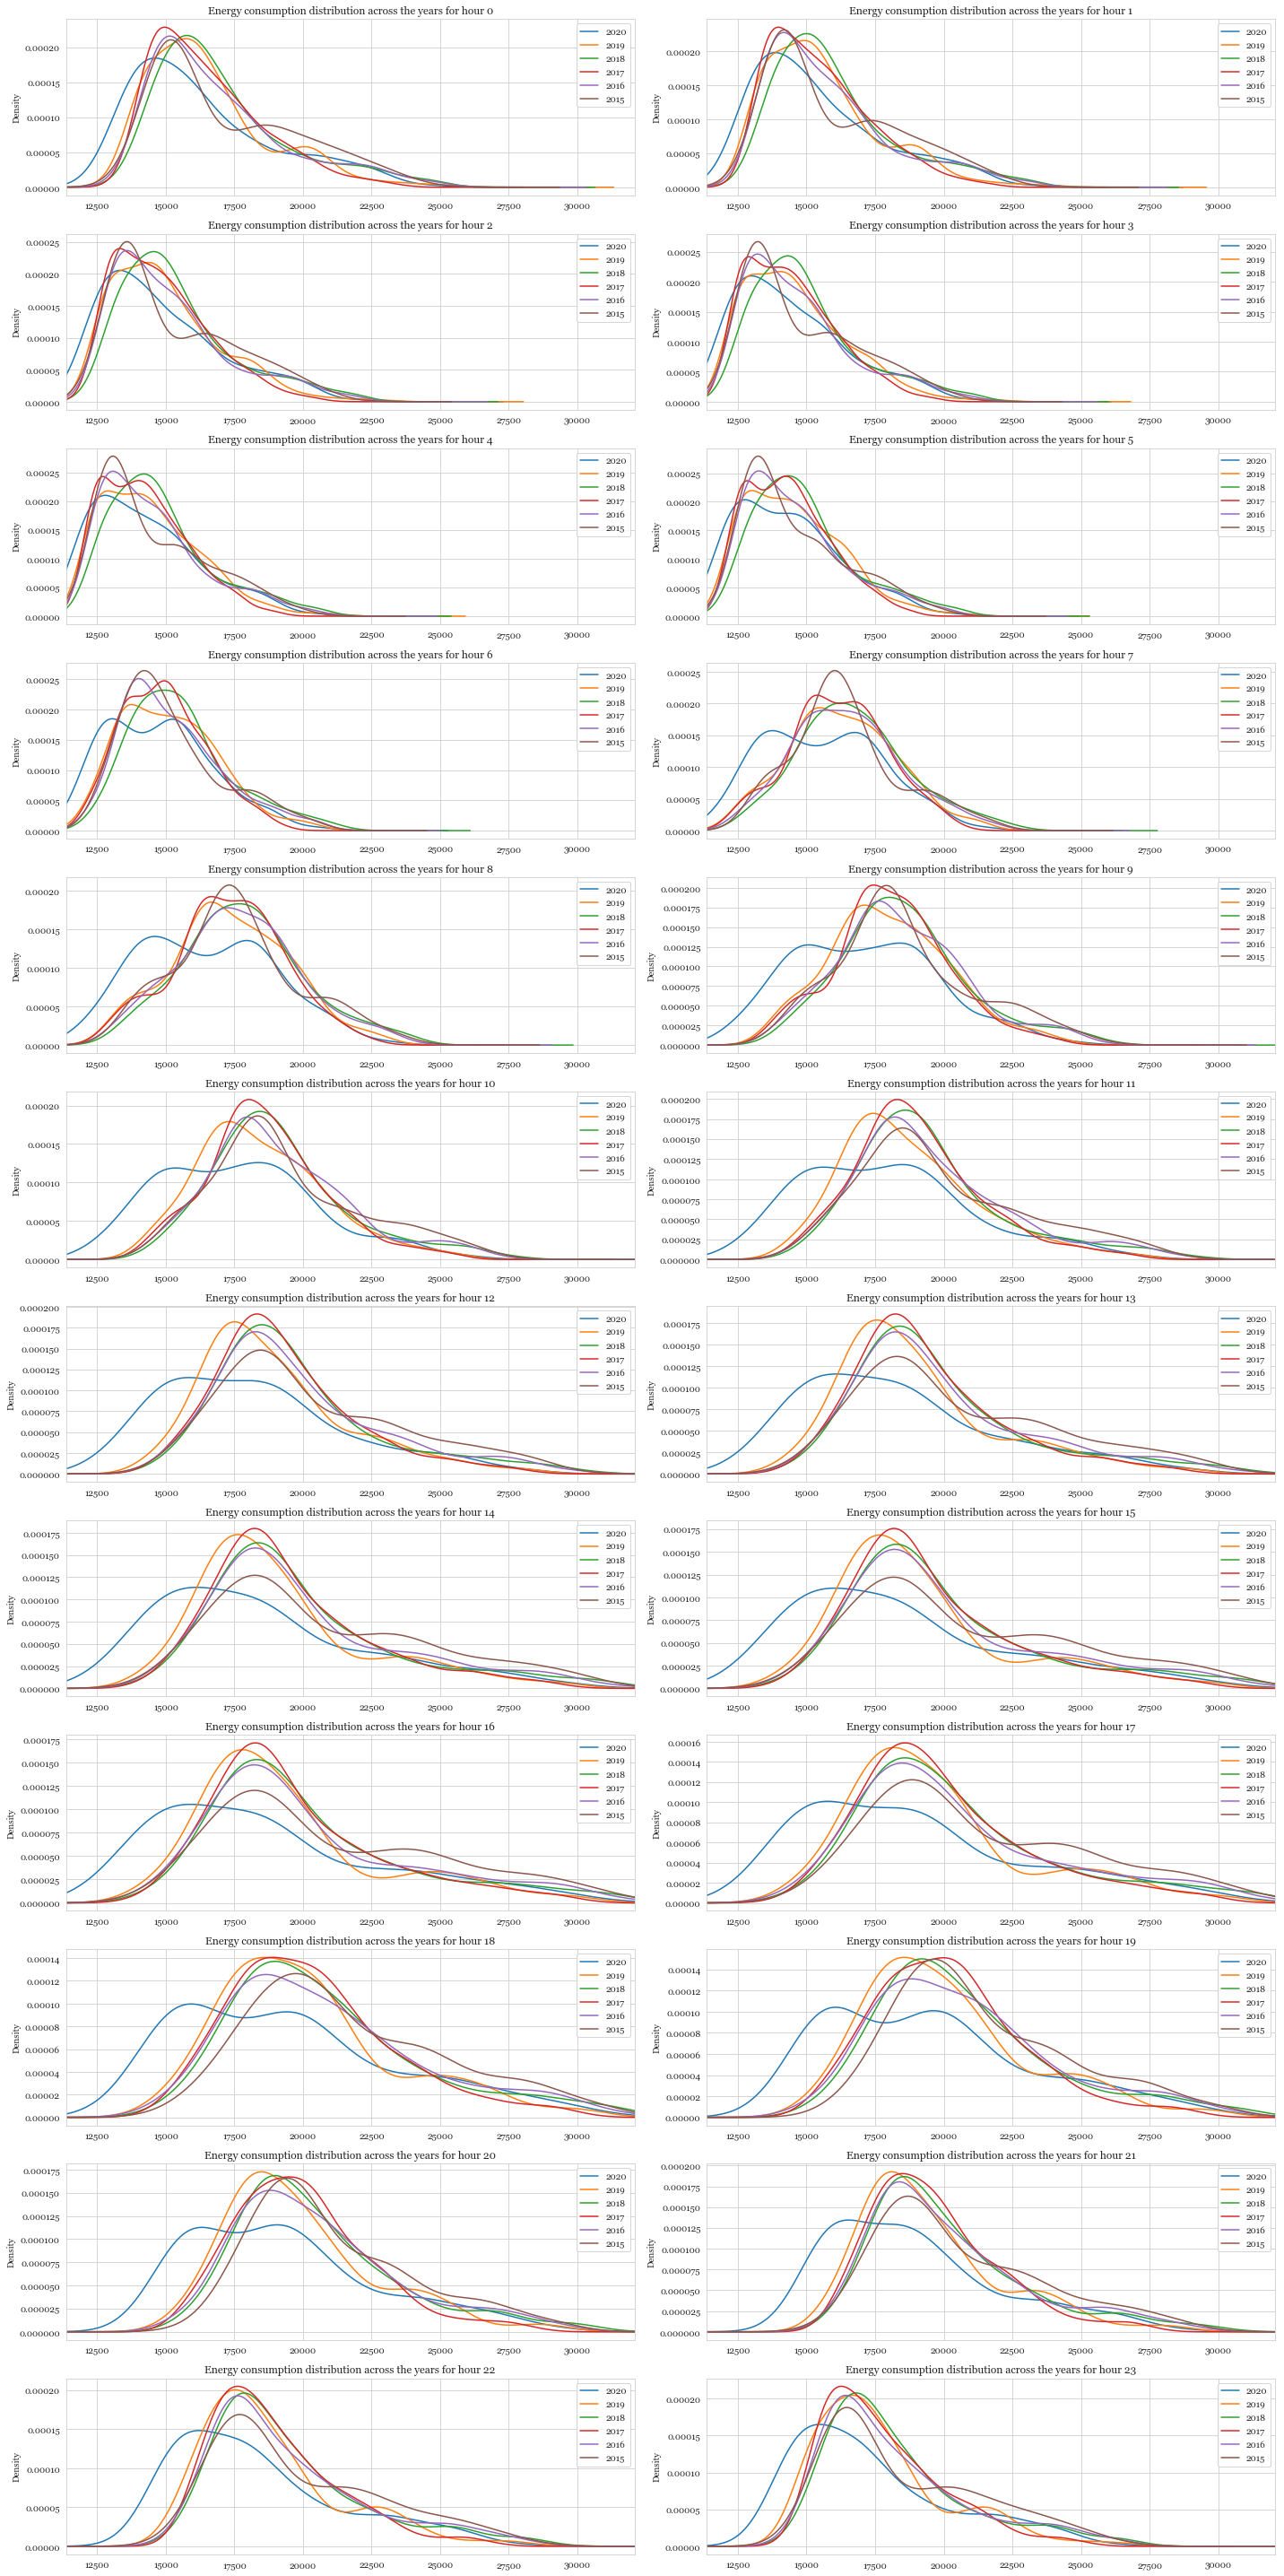

In [17]:
#plotting distribution for over the years hourly

f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['year'].unique()):
        df[(df['year'] == year) & (df['hour'] == hour)]['Consumption'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
                               
    plt.title('Energy consumption distribution across the years for hour '+str(hour))
    plt.xlim(np.min(df.Consumption.values), np.max(df.Consumption.values))
plt.tight_layout()


We can see from the above graphs that the energy consumption distribution for each hour has shifted towards lower energy consumption values 

# Adding Weather Data

In [18]:
df = pd.read_csv('new_york.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True)

#change to EST 
df['Date'] = df['Date'].dt.tz_convert('US/Eastern')

df.index = df.Date
#df = df.drop('Date', axis=1)
df = df[df['Consumption'] != 0]

df = df.resample('D').sum()

Text(0, 0.5, 'Temperature')

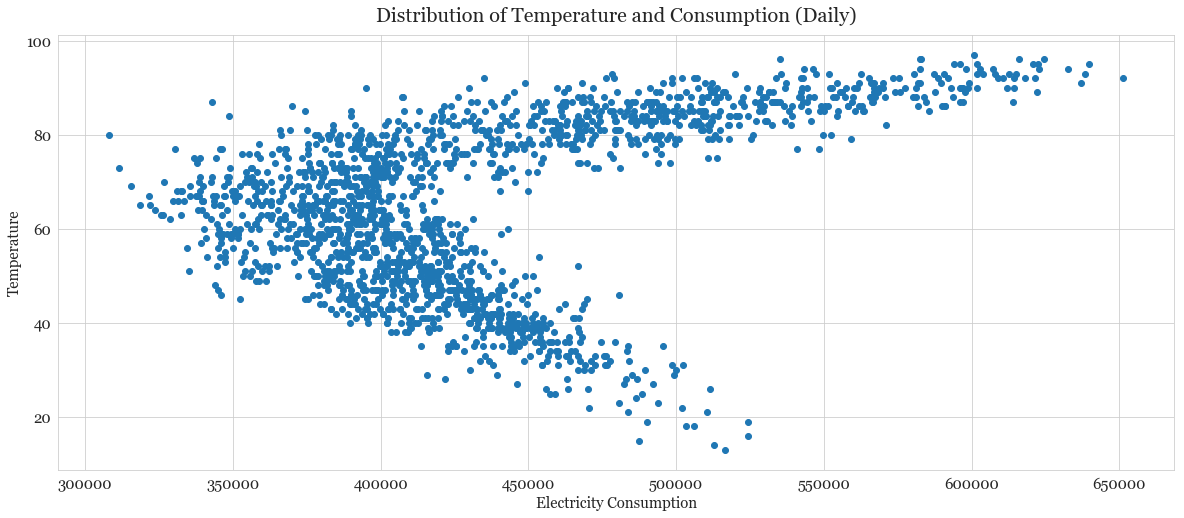

In [19]:

df = df.sort_index()

df2 = df['2015-07-01':'2020-08-10']

nyc_weather = pd.read_csv('weatherNY.csv')
nyc_weather['DATE'] = pd.to_datetime(nyc_weather['DATE'])
nyc_weather = nyc_weather.set_index('DATE')
nyc_weather.drop(['NAME','STATION'],axis=1,inplace=True)
nyc_weather = nyc_weather['2015-07-01':'2020-08-10']


plt.figure(figsize=[20,8])
plt.scatter(y = nyc_weather.TMAX.values, x=df2.Consumption.values)
plt.title('Distribution of Temperature and Consumption (Daily)', fontsize = 20,pad = 13)
plt.tick_params(labelsize=15)
plt.xlabel('Electricity Consumption',fontsize=15)
plt.ylabel('Temperature',fontsize=15)

# Time Series Modeling

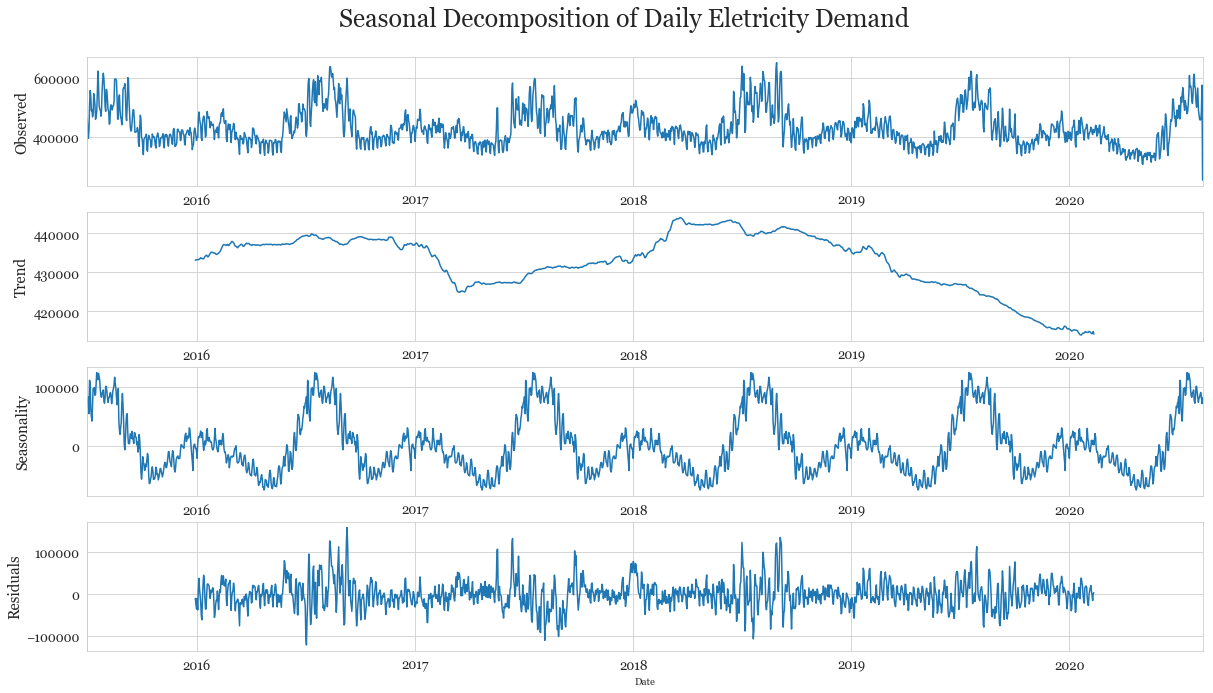

In [20]:
import statsmodels.api as sm


res = sm.tsa.seasonal_decompose(df.Consumption, model='additive', freq=365)


fig = plt.figure(figsize=(20, 10))

ax0 = plt.subplot(4, 1, 1)
res.observed.plot()
ax0.set_ylabel('Observed', fontsize=15)
ax0.xaxis.set_tick_params(labelsize=13)
ax0.yaxis.set_tick_params(labelsize=13)

ax1 = plt.subplot(4, 1, 2)
res.trend.plot()
ax1.set_ylabel('Trend', fontsize=15)

ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)

ax2 =  plt.subplot(4, 1, 3)
res.seasonal.plot()

ax2.xaxis.set_tick_params(labelsize=13)
ax2.yaxis.set_tick_params(labelsize=13)

ax2.set_ylabel('Seasonality',fontsize=15)
ax3 = plt.subplot(4,1,4)
res.resid.plot()
ax3.set_ylabel('Residuals',fontsize=15)

ax3.xaxis.set_tick_params(labelsize=13)
ax3.yaxis.set_tick_params(labelsize=13)

plt.suptitle('Seasonal Decomposition of Daily Eletricity Demand ',y =1.02, fontsize=25)

fig.subplots_adjust(top=0.95)

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results



def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x,of, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(15, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)
    ax[0].set_title("Autocorrelation (ACF)", fontsize = 14)
    ax[0].set_xlabel('Lags')
    ax[0].xaxis.set_tick_params(labelsize=14)
    ax[0].yaxis.set_tick_params(labelsize=14)
    ax[1].set_title("Partial Autocorrelation (PACF)", fontsize = 14)
    ax[1].set_xlabel('Lags')
    ax[1].xaxis.set_tick_params(labelsize=14)
    ax[1].yaxis.set_tick_params(labelsize=14)
    fig.suptitle(f'ACF and PACF of {of}', y=1.03, fontsize=20)
    fig.tight_layout()
    
    return fig

ADF test statistic: -4.71 (p-val: 0.00)
KPSS test statistic: 0.18 (p-val: 0.10)


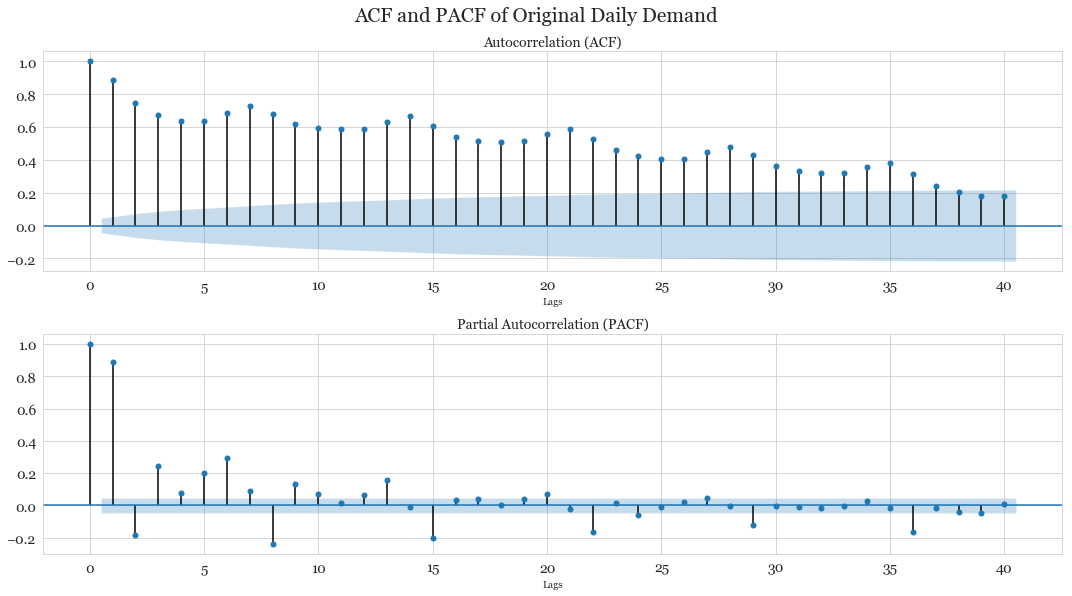

In [22]:
test_autocorrelation(df.Consumption, 'Original Daily Demand')

plt.tight_layout()

# Seven day differencing

In [23]:
adjusted = df.Consumption.diff(7)

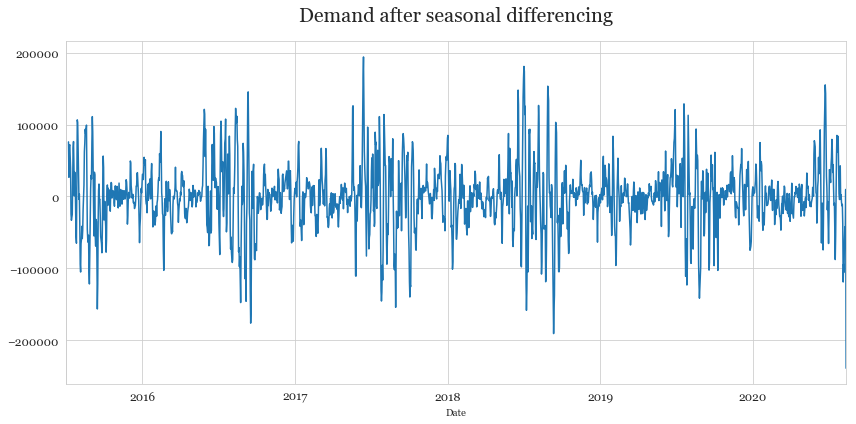

In [24]:
plt.figure(figsize = (12,6))
adjusted.plot()
plt.title('Demand after seasonal differencing', fontsize=20, pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

ADF test statistic: -7.95 (p-val: 0.00)
KPSS test statistic: 0.02 (p-val: 0.10)


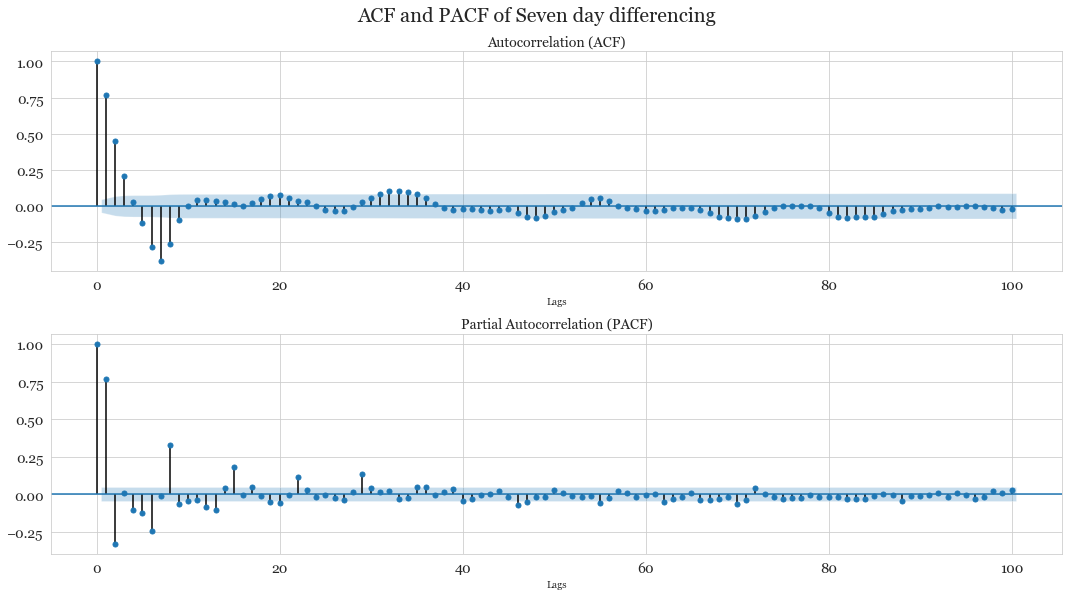

In [25]:
fig = test_autocorrelation(adjusted[7:], of='Seven day differencing', n_lags=100)
plt.tight_layout()

ADF test statistic: -15.15 (p-val: 0.00)
KPSS test statistic: 0.05 (p-val: 0.10)


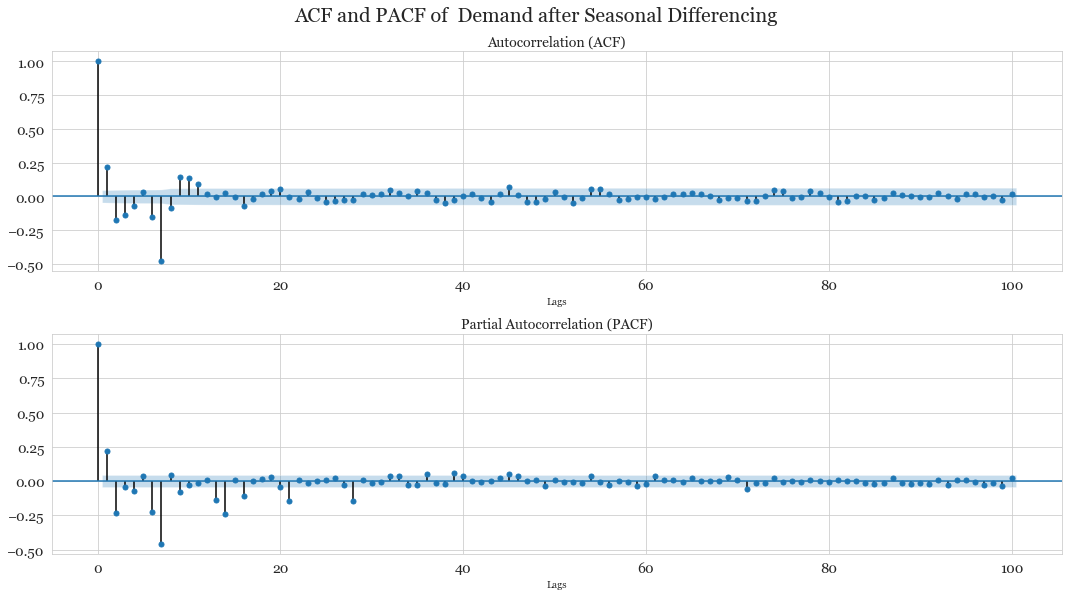

In [26]:
adjusted1 = adjusted.diff(1)
fig = test_autocorrelation(adjusted1[8:],of=' Demand after Seasonal Differencing',n_lags=100)
plt.tight_layout()

In [27]:
tr_start,tr_end = '2015-01-01','2019-12-31'
te_start,te_end = '2020-01-01','2020-02-15'

te_start,te_end = '2020-01-01','2020-02-15'

train = df['Consumption'][tr_start:tr_end].dropna().tz_localize(None)
test = df['Consumption'][te_start:te_end].dropna().tz_localize(None)



In [28]:
# fit SARIMA based on helper plotsP
sar = sm.tsa.statespace.SARIMAX(train, 
                                order=(2,1,3), 
                                seasonal_order=(2,1,1,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

Optimization terminated successfully.
         Current function value: 11.329852
         Iterations: 6
         Function evaluations: 634


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Consumption   No. Observations:                 1645
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 7)   Log Likelihood              -18637.606
Date:                             Sat, 17 Oct 2020   AIC                          37293.213
Time:                                     10:34:57   BIC                          37341.818
Sample:                                 07-01-2015   HQIC                         37311.241
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1800     13.099      0.014      0.989     -25.493      25.853
ar.L2          0.3443      8.990      0.038      0.969     -17.276      17.964
ma.L1          0.0306     13.097      0.002      0.998     -25.640      25.701
ma.L2         -0.5978      6.235     -0.096      0.924     -12.818      11.622
ma.L3         -0.1825      4.710     -0.039      0.969      -9.414       9.049
ar.S.L7        0.1450      0.018      8.189      0.000       0.110       0.180
ar.S.L14       0.0100      0.011      0.947      0.344      -0.011       0.031
ma.S.L7       -0.9473      0.011    -84.767      0.000      -0.969      -0.925
sigma2      4.498e+08   1.31e-06   3.43e+14      0.000     4.5e+08     4.5e+08
===================================================================================
Ljung-Box (Q):                      100.44   Jarque-Bera (JB):               922.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.43
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+30. Standard errors may be unstable.
"""

In [29]:
pred = sar.predict(tr_end,te_end)[1:]

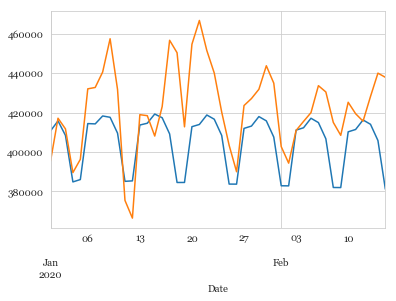

In [30]:
pred.plot()
test.plot()

In [31]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=922.430, p=0.000
Ljung-Box: val=100.444, p=0.000
Heteroskedasticity: val=0.897, p=0.204
Durbin-Watson: d=1.98


In [32]:
pd.date_range(nyc_weather.index.min(), nyc_weather.index.max()).difference(nyc_weather.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [ ]:
test_autocorrelation(df.Consumption,of='Multiple Seasonality for 2 Years',n_lags=365*2)
plt.tight_layout()

__Adding Exog Variables__

In [110]:

df = pd.read_csv('new_york.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.index = df.Date
df = df.resample('D').sum()
df = df.tz_localize(None)
df = df[:'2020-08-10']

nyc_weather = pd.read_csv('weatherNY.csv')
nyc_weather['DATE'] = pd.to_datetime(nyc_weather['DATE'])
nyc_weather = nyc_weather.set_index('DATE')
nyc_weather.drop(['NAME','STATION'],axis=1,inplace=True)
nyc_weather = nyc_weather['2015-07-01':'2020-08-10']
# Getting data from only 2016 to 2020 as 2015 is incomplete. 
df1 = df["2016":]
nyc_weather = nyc_weather["2016":]



In [77]:
# testing optimal fourier terms:
def optimal_exog_search(y=df1.Consumption, weather=nyc_weather['TMIN'].values):
    exog_trial = pd.DataFrame({'date': y.index})
    exog_trial = exog_trial.set_index(pd.PeriodIndex(exog_trial['date'], freq='D'))
    exog_trial['is_weekend'] = np.where(exog_trial.index.dayofweek < 5,0,1)
    exog_trial['TMIN'] =weather
    exog_trial= exog_trial.drop(columns=['date'])
    
    models = {}
    for i in range(1,8):
        if i ==1:
            exog_trial[f'sin1'] = np.sin(np.pi * exog_trial.index.dayofyear / 365.25)
            exog_trial[f'cos1'] = np.cos(np.pi * exog_trial.index.dayofyear / 365.25)
            exog_trial[f'sin1'] = np.sin(np.pi * exog_trial.index.dayofyear / 150)
            exog_trial[f'cos1'] = np.cos(np.pi * exog_trial.index.dayofyear / 150)
        else:
            for j in range(1,i+1):
                exog_trial[f'sin{j}'] = np.sin(j * np.pi * exog_trial.index.dayofyear / 365.25)
                exog_trial[f'cos{j}'] = np.cos(j * np.pi * exog_trial.index.dayofyear / 365.25)
                exog_trial[f'sin{j}'] = np.sin(j * np.pi * exog_trial.index.dayofyear / 150)
                exog_trial[f'cos{j}'] = np.cos(j * np.pi * exog_trial.index.dayofyear / 150)

        test = len(y) - 100 
        y_to_train = y.iloc[:test]    
        exog_trial_to_train = exog_trial.iloc[:test]
        arima_exog_trial_model = auto_arima(y=y_to_train, exogenous=exog_trial_to_train, seasonal=True, m=7, error_action='ignore',suppress_warnings=True) 
        model = f'{str(arima_exog_trial_model.order)}{str(arima_exog_trial_model.seasonal_order)} + Number of Exog: {i}'
        models[model] = arima_exog_trial_model.aic()

    min_aic_key = min(models.keys(), key=(lambda k: models[k]))
    print('Best model: {}, AIC: {}'.format(min_aic_key , models[min_aic_key]))


In [78]:
optimal_exog_search(df1.Consumption)

Best model: (1, 1, 3)(2, 0, 1, 7) + Number of Exog: 5, AIC: 35689.827416808985


In [128]:
from pmdarima.arima import ARIMA

def sarimax_run(y=df1.Consumption, n_fourier=5, weather=nyc_weather['TMIN'].values, window=1, total_predictions=30, plot_graph=True):
    day = window
    true_values = []
    predictions = []
    dates = []
    num_to_update = 0
    
    exog = pd.DataFrame({'date': y.index})
    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    exog['is_weekend'] = np.where(exog.index.dayofweek < 5,0,1)
    exog['TMIN'] =weather
    exog= exog.drop(columns=['date'])
    
    #add exog
    for j in range(1,n_fourier+1):
        exog[f'sin{j}'] = np.sin(j * np.pi * exog.index.dayofyear / 365.25)
        exog[f'cos{j}'] = np.cos(j * np.pi * exog.index.dayofyear / 365.25)
        exog[f'sin{j}'] = np.sin(j * np.pi * exog.index.dayofyear / 150)
        exog[f'cos{j}'] = np.cos(j * np.pi * exog.index.dayofyear / 150)
    
    for i in range(total_predictions):
        test = len(y) - 100 
        y_to_train = y.iloc[:test]    
        exog_to_train = exog.iloc[:test]

        #first iteration train the model
        if i == 0:
            #(1, 1, 3)(2, 0, 1, 7)
           # arima_exog_model = ARIMA(order=(1, 1, 3), seasonal_order=(2, 0, 1, 7), exogenous=exog_to_train, error_action='ignore',suppress_warnings=True).fit(y=y_to_train)  
            arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7, error_action='ignore',suppress_warnings=True) 
            preds = arima_exog_model.predict_in_sample(exog_to_train)   
            
            #print(arima_exog_model.aic())
            preds = preds.to_timestamp()       
            #first prediction
            y_to_test = y.iloc[test:test+day]
            y_exog_to_test = exog.iloc[test:test+day]
            y_arima_exog_forecast = arima_exog_model.predict(n_periods=day, exogenous=y_exog_to_test)
            true_values.append(y_to_test.values)
            predictions.append(y_arima_exog_forecast.tolist())
            dates.append(y_to_test.index)
        
        else:
            y_to_update = y.iloc[test+num_to_update:test+num_to_update+day]
            exog_to_update = exog.iloc[test+num_to_update:test+num_to_update+day]
            #to test
            to_test = y.iloc[test+num_to_update+day:test+num_to_update+(day*2)]
            exog_to_test = exog.iloc[test+num_to_update+day:test+num_to_update+(day*2)]
            #update the model
            arima_exog_model.update(y_to_update,exogenous=exog_to_update)
            y_arima_exog_forecast = arima_exog_model.predict(n_periods=day, exogenous=exog_to_test)
            dates.append(to_test.index)
            predictions.append(y_arima_exog_forecast.tolist())    
            true_values.append(to_test.values)
            num_to_update += day

    dates = [item for sublist in dates for item in sublist]
    frequency = [dates[i] for i in range(0, len(dates), day)]
    predict =  [item for sublist in predictions for item in sublist]
    true = [item for sublist in true_values for item in sublist]
    
    if plot_graph:
        fig, ax = plt.subplots(figsize=(25,6))

        label_added = False
        for p in frequency:
            if not label_added:
                plt.axvline(p, color='black', linestyle='--', linewidth=2, alpha=0.3, label=f'Prediction window = {day} day(s)')
                label_added = True
            else:
                plt.axvline(p, color='black', linestyle='--', linewidth=2, alpha=0.3)

        train_plot = y_to_train[-20:]
        train_plot[dates[0]] = true[0]
        preds_plot = preds[-20:]
        preds_plot[dates[0]] = predict[0]
        
        plt.plot(train_plot,c='#ff5e15', linewidth=2, label='')
        plt.plot(preds_plot,color='#62cfde', linestyle='-.',  linewidth=2, label='In-sample Prediction')
        plt.plot(dates,true, c='#ff5e15', linewidth=2,label='True')
        plt.plot(dates,predict, color='#5175bc',linewidth=1.2,label='Predicted')
        plt.title(f'Predicted Electricy Demand for {day} day(s) for SARIMAX' + 
                  f'{str(arima_exog_model.order)}{str(arima_exog_model.seasonal_order)} ', fontsize=25, pad=20)
        plt.yticks(fontsize=13)
        plt.ylabel('Energy Demand in MWh', fontsize=20)
        plt.xlabel('Predicted Dates', fontsize=20)
        plt.legend(fontsize=12)    
        plt.grid([])
        plt.xticks(frequency,[frequency[i].date().strftime('%Y-%m-%d') for i in range(len(frequency))],fontsize=13)
        plt.xticks(rotation=40)
        plt.xlim([y_to_train[-20:].index[0],dates[-1]])
        plt.show()


        #using absolute values of true - predict as forecast_errors.
        forecast_errors = [np.abs(true[i]-predict[i]) for i in range(len(predict))]
        fig, ax = plt.subplots(figsize=(15,4))
        plt.plot(dates,forecast_errors, c='#d23a47', linewidth=2)
        plt.title('Errors for the Prediction',fontsize=25, pad=20)
        plt.xticks(frequency,[frequency[i].date().strftime('%Y-%m-%d') for i in range(len(frequency))],fontsize=13)
        plt.xticks(rotation=40)
        plt.xlim([dates[0],dates[-1]])
        plt.yticks(fontsize=13)
        plt.ylabel('Absolute Errors', fontsize=20)
        plt.xlabel('Predicted Dates', fontsize=20)  
        plt.show()
        
  #  with open('arima_errors_cali.pkl', 'wb') as f:
  #      pickle.dump(forecast_errors, f)
  #      print('success')
            

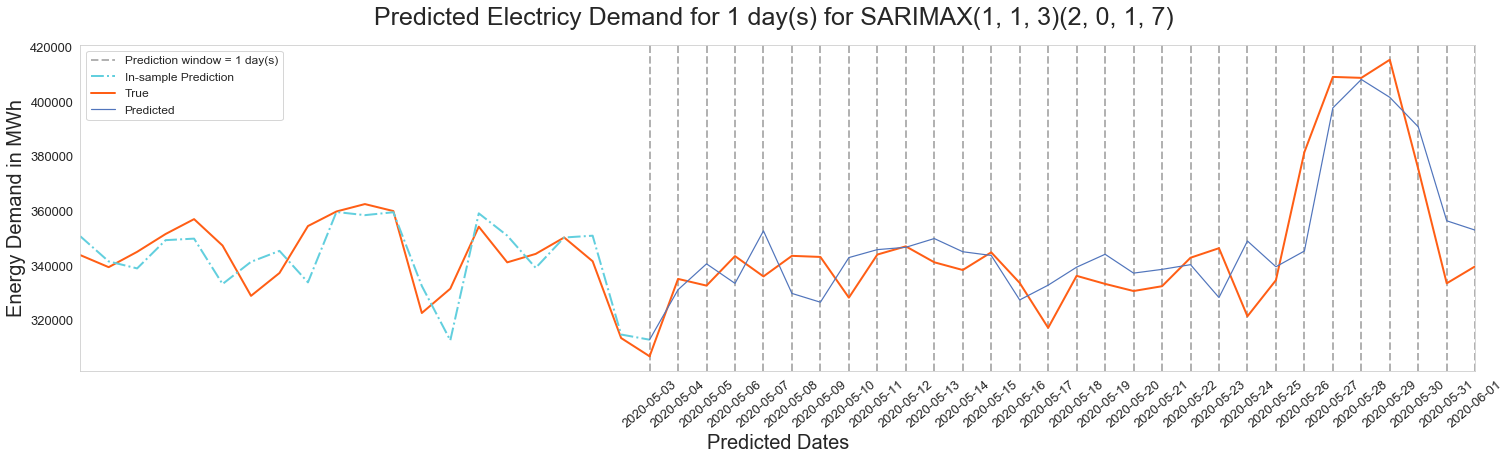

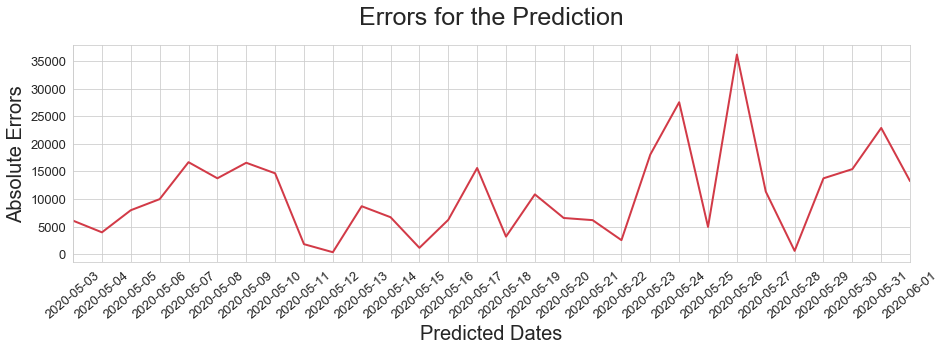

success


In [127]:
sarimax_run()

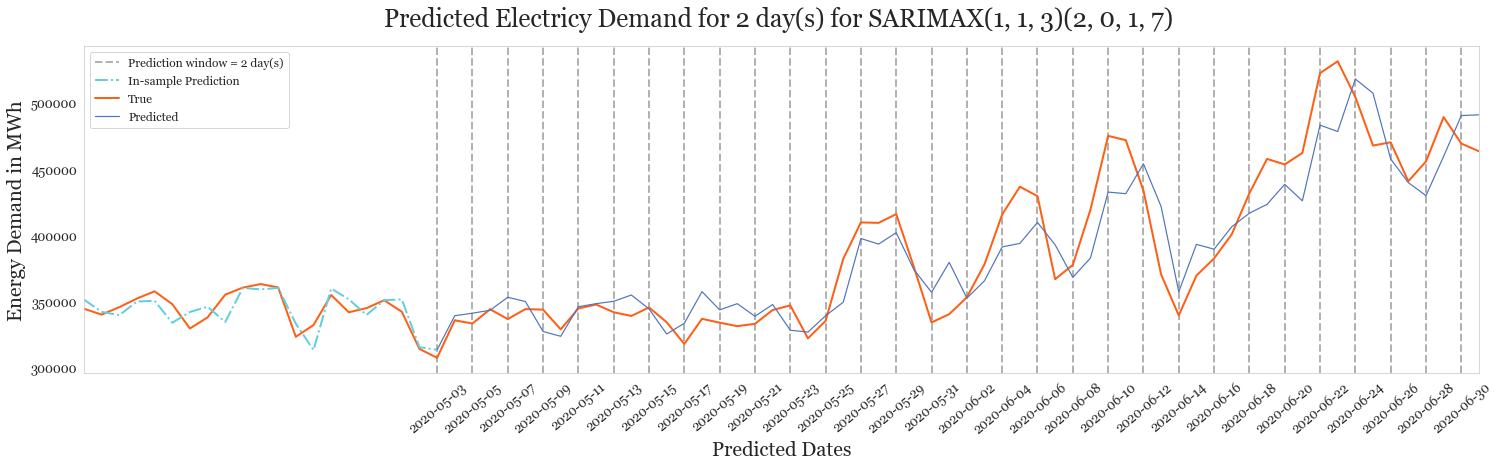

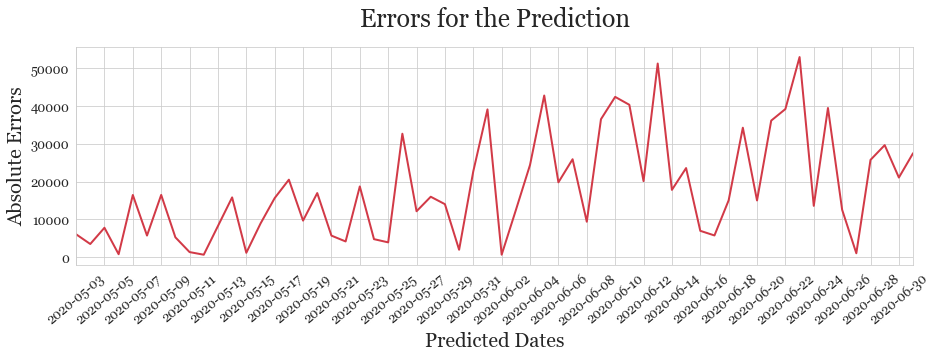

In [95]:
sarimax_run(y=df1.Consumption, n_fourier=5, weather=nyc_weather['TMIN'].values, window=2, total_predictions=30, plot_graph=True)

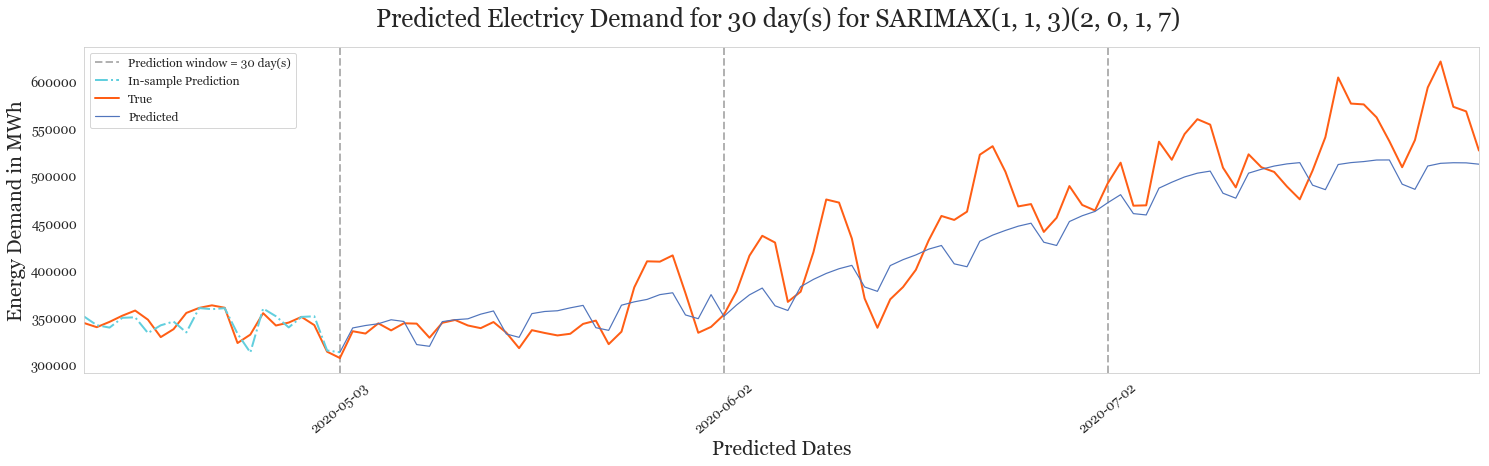

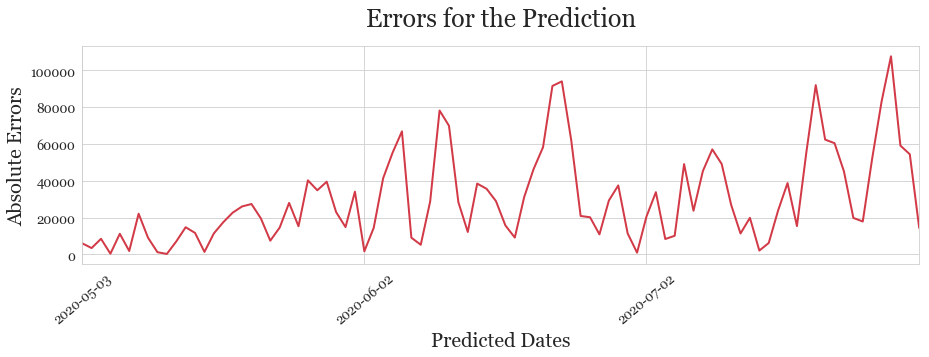

In [119]:
sarimax_run(y=df1.Consumption, n_fourier=5, weather=nyc_weather['TMIN'].values, window=30, total_predictions=3, plot_graph=True)

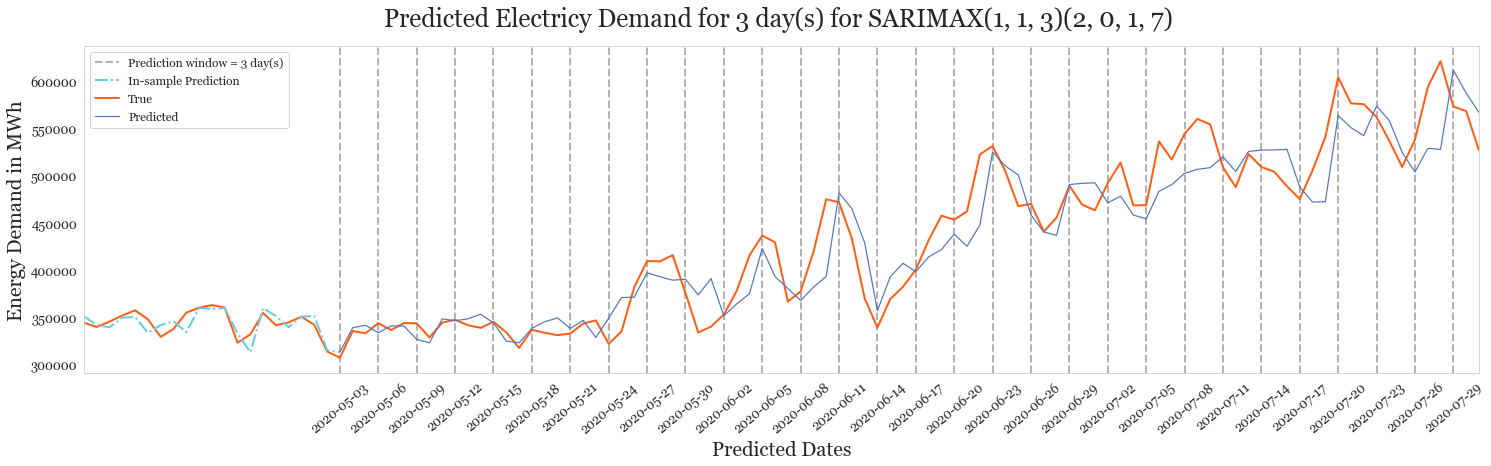

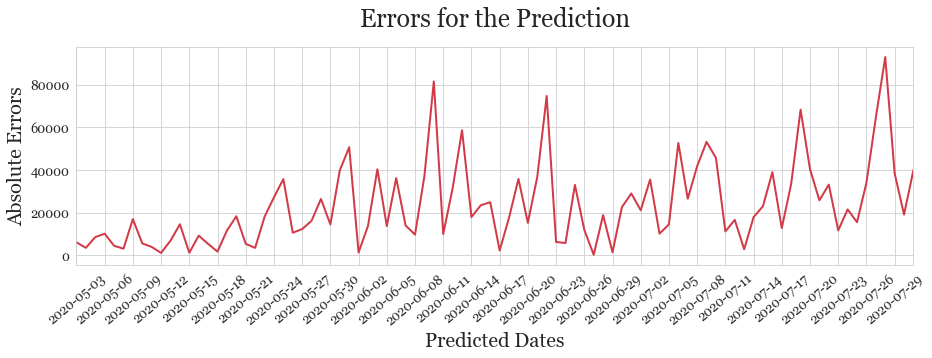

In [98]:
sarimax_run(y=df1.Consumption, n_fourier=5, weather=nyc_weather['TMIN'].values, window=3, total_predictions=30, plot_graph=True)

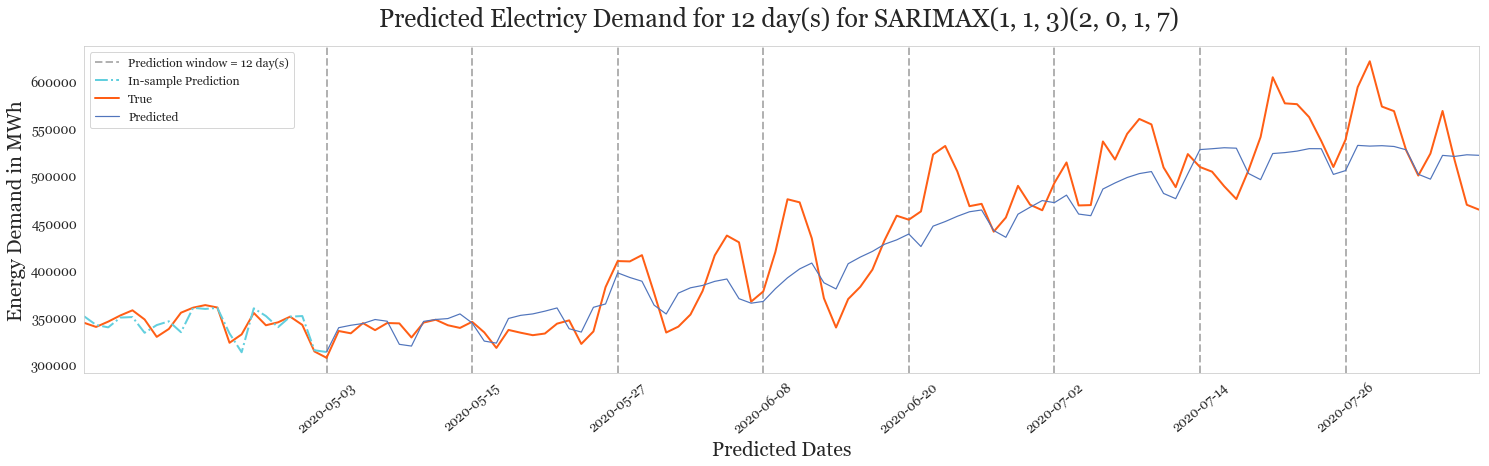

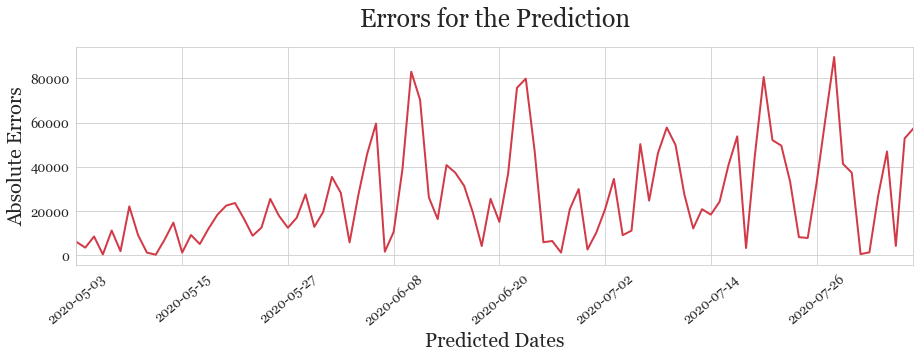

In [116]:
sarimax_run(y=df1.Consumption, n_fourier=5, weather=nyc_weather['TMIN'].values, window=30, total_predictions=3, plot_graph=True)

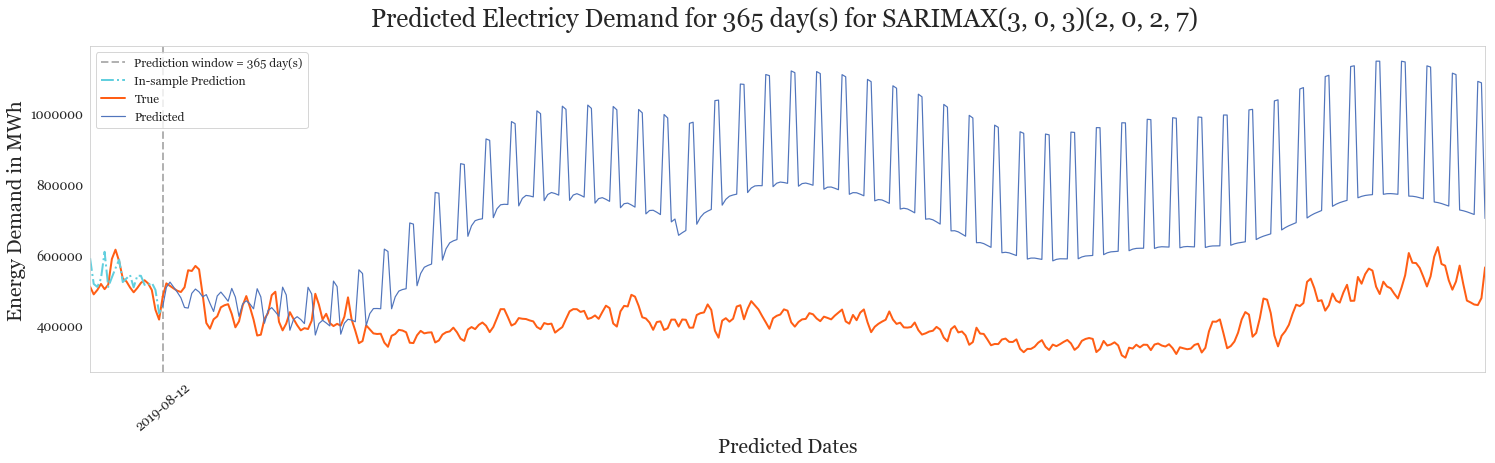

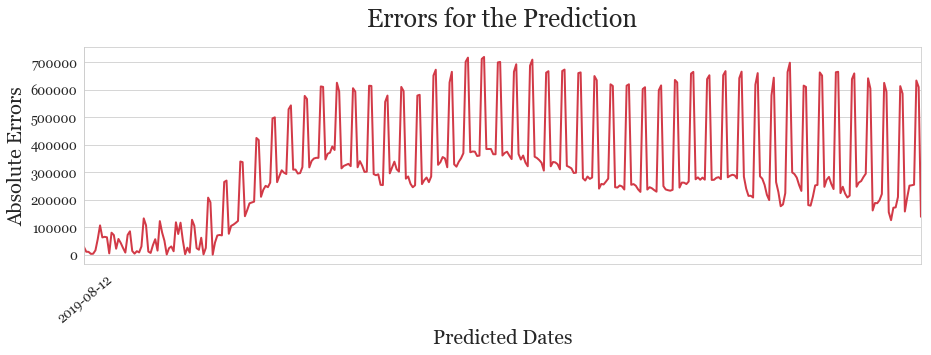

In [111]:
def yearly_sarimax_run(y=df1.Consumption, n_fourier=5, window=365, plot_graph=True):
    day = window
    true_values = []
    predictions = []
    dates = []
    exog = pd.DataFrame({'date': y.index})
    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    exog['is_weekend'] = np.where(exog.index.dayofweek < 5,0,1)
    exog= exog.drop(columns=['date'])
    
    #add exog
    for j in range(1,n_fourier+1):
        exog[f'sin{j}'] = np.sin(j * np.pi * exog.index.dayofyear / 365.25)
        exog[f'cos{j}'] = np.cos(j * np.pi * exog.index.dayofyear / 365.25)
        exog[f'sin{j}'] = np.sin(j * np.pi * exog.index.dayofyear / 150)
        exog[f'cos{j}'] = np.cos(j * np.pi * exog.index.dayofyear / 150)
    

    test = len(y) - 365
    y_to_train = y.iloc[:test]    
    exog_to_train = exog.iloc[:test]
    arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7, error_action='ignore',suppress_warnings=True) 
    preds = arima_exog_model.predict_in_sample(exog_to_train)   
    preds = preds.to_timestamp()       
    y_to_test = y.iloc[test:]
    y_exog_to_test = exog.iloc[test:]
    y_arima_exog_forecast = arima_exog_model.predict(n_periods=day, exogenous=y_exog_to_test)
    true_values.append(y_to_test.values)
    predictions.append(y_arima_exog_forecast.tolist())
    dates.append(y_to_test.index)

    dates = [item for sublist in dates for item in sublist]
    frequency = [dates[i] for i in range(0, len(dates), day)]
    predict =  [item for sublist in predictions for item in sublist]
    true = [item for sublist in true_values for item in sublist]
    
    if plot_graph:
        fig, ax = plt.subplots(figsize=(25,6))
        label_added = False
        for p in frequency:
            if not label_added:
                plt.axvline(p, color='black', linestyle='--', linewidth=2, alpha=0.3, label=f'Prediction window = {day} day(s)')
                label_added = True
            else:
                plt.axvline(p, color='black', linestyle='--', linewidth=2, alpha=0.3)

        train_plot = y_to_train[-20:]
        train_plot[dates[0]] = true[0]
        preds_plot = preds[-20:]
        preds_plot[dates[0]] = predict[0]
        
        plt.plot(train_plot,c='#ff5e15', linewidth=2, label='')
        plt.plot(preds_plot,color='#62cfde', linestyle='-.',  linewidth=2, label='In-sample Prediction')
        plt.plot(dates,true, c='#ff5e15', linewidth=2,label='True')
        plt.plot(dates,predict, color='#5175bc',linewidth=1.2,label='Predicted')
        plt.title(f'Predicted Electricy Demand for {day} day(s) for SARIMAX' + 
                  f'{str(arima_exog_model.order)}{str(arima_exog_model.seasonal_order)} ', fontsize=25, pad=20)
        plt.yticks(fontsize=13)
        plt.ylabel('Energy Demand in MWh', fontsize=20)
        plt.xlabel('Predicted Dates', fontsize=20)
        plt.legend(fontsize=12)    
        plt.grid([])
        plt.xticks(frequency,[frequency[i].date().strftime('%Y-%m-%d') for i in range(len(frequency))],fontsize=13)
        plt.xticks(rotation=40)
        plt.xlim([y_to_train[-20:].index[0],dates[-1]])
        plt.show()

        #using absolute values of true - predict as forecast_errors.
        forecast_errors = [np.abs(true[i]-predict[i]) for i in range(len(predict))]
        fig, ax = plt.subplots(figsize=(15,4))
        plt.plot(dates,forecast_errors, c='#d23a47', linewidth=2)
        plt.title('Errors for the Prediction',fontsize=25, pad=20)
        plt.xticks(frequency,[frequency[i].date().strftime('%Y-%m-%d') for i in range(len(frequency))],fontsize=13)
        plt.xticks(rotation=40)
        plt.xlim([dates[0],dates[-1]])
        plt.yticks(fontsize=13)
        plt.ylabel('Absolute Errors', fontsize=20)
        plt.xlabel('Predicted Dates', fontsize=20)  
        plt.show()
        
yearly_sarimax_run()


# Trying California

In [129]:

#trying 1 day increments with EXOG. MAYBE BEST CANDIDATE? with fourier terms june to june as 638 and august to august 516

cali_df = pd.read_csv('california_sample.csv')
cali_df.columns = ['Date','Consumption']
cali_df['Date'] = pd.to_datetime(cali_df['Date'], utc=True)
cali_df.index = cali_df.Date
cali_df = cali_df.sort_index()


#converting data to daily usage.
cali_df = cali_df.drop('Date', axis=1)
# resample the dataframe every 1 day (D) and sum ovr each day
cali_df = cali_df.resample('D').sum()
cali_df = cali_df.tz_localize(None)
cali_df = cali_df[:'2020-08-10']



california_weather = pd.read_csv('california_weather.csv')
california_weather['DATE'] = pd.to_datetime(california_weather['DATE'])
california_weather = california_weather.set_index('DATE')
california_weather.drop(['STATION','LATITUDE','LONGITUDE','ELEVATION','TMAX','TMIN'],axis=1,inplace=True)
california_weather = california_weather['2015-07-01':'2020-08-09']

#check for missing data 



In [130]:
#for weather data
pd.date_range(california_weather.index.min(), california_weather.index.max()).difference(california_weather.index)
california_weather.loc['2016-02-19'],california_weather.loc['2016-02-22']

(TAVG    48
 Name: 2016-02-19 00:00:00, dtype: int64,
 TAVG    47
 Name: 2016-02-22 00:00:00, dtype: int64)

In [131]:
#using the same temperature from the earlier day as it wont make any significant difference. Difference in Weather between two days would not be too drastic
california_weather.loc[pd.to_datetime('2016-02-20')] = 48
california_weather.loc[pd.to_datetime('2016-02-21')] = 47
california_weather = california_weather.sort_index()

cali_df1 = cali_df["2016":"2020"]
california_weather = california_weather["2016":"2020"]

y = cali_df1.Consumption
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['is_weekend'] = np.where(exog.index.dayofweek < 5,0,1)

In [132]:
len(y),len(california_weather)

(1683, 1683)

In [83]:
optimal_exog_search(y=y, weather=california_weather['TAVG'].values)

Best model: (5, 1, 3)(2, 0, 0, 7) + Number of Exog: 6, AIC: 36688.154901020665


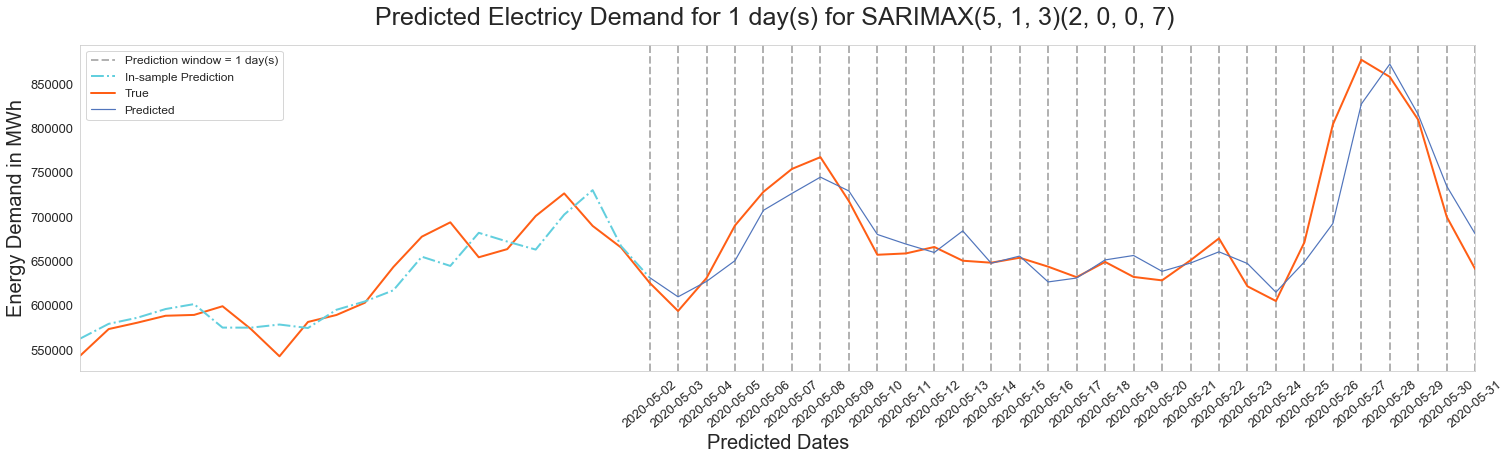

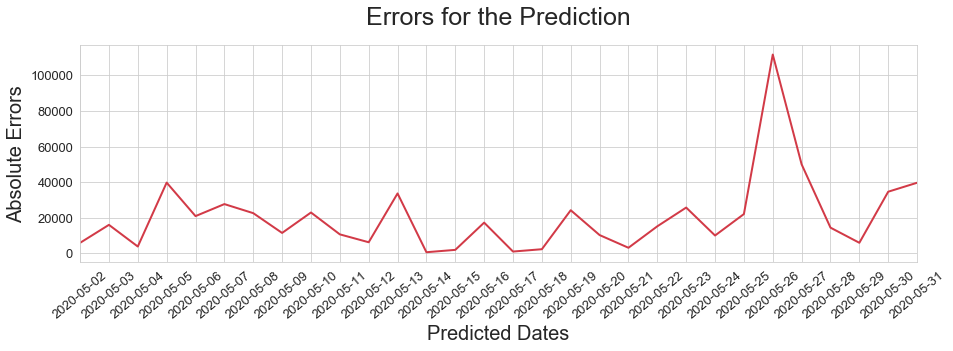

success


In [133]:
sarimax_run(y=y, n_fourier=6, weather=california_weather['TAVG'].values, window=1, total_predictions=30, plot_graph=True)

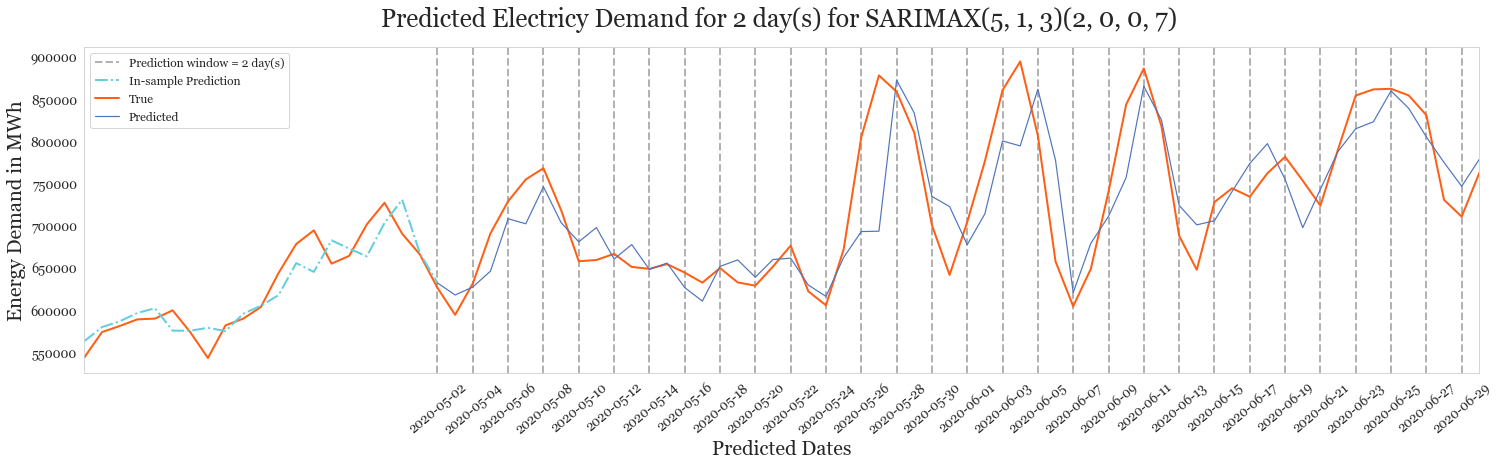

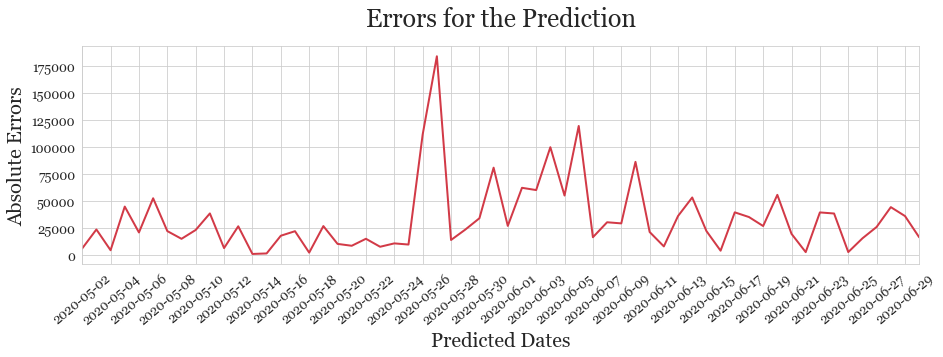

In [106]:
sarimax_run(y=y, n_fourier=6, weather=california_weather['TAVG'].values, window=2, total_predictions=30, plot_graph=True)

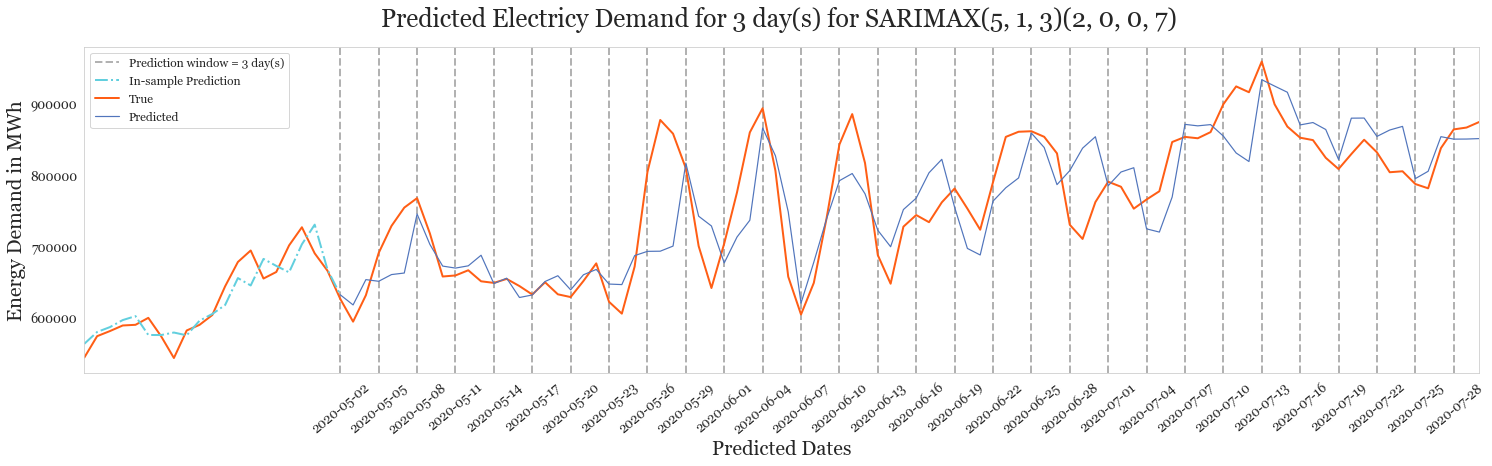

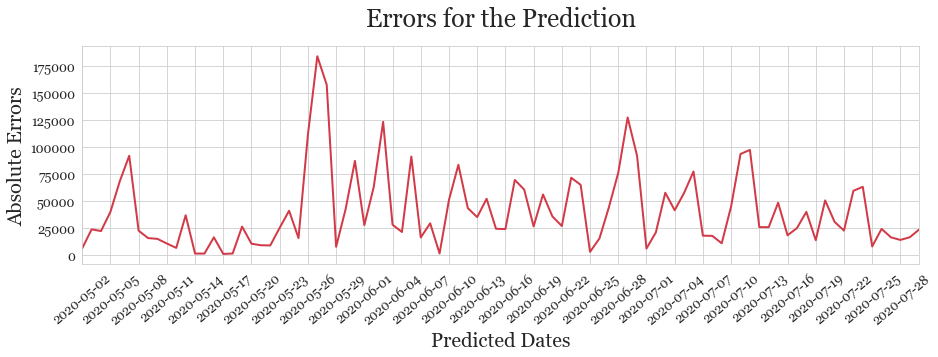

In [107]:
sarimax_run(y=y, n_fourier=6, weather=california_weather['TAVG'].values, window=3, total_predictions=30, plot_graph=True)

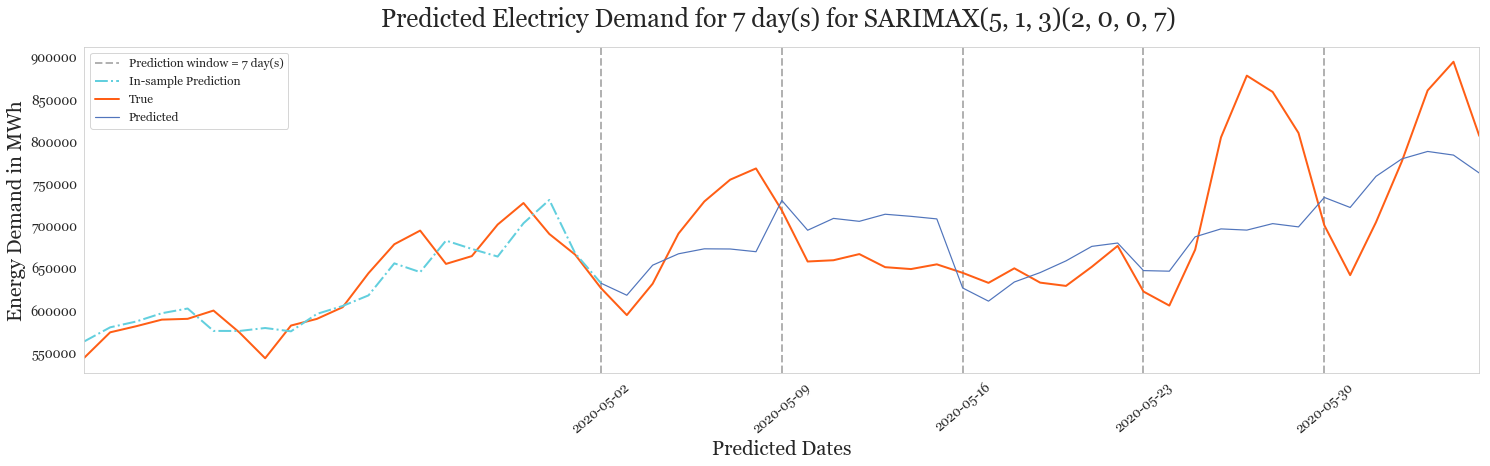

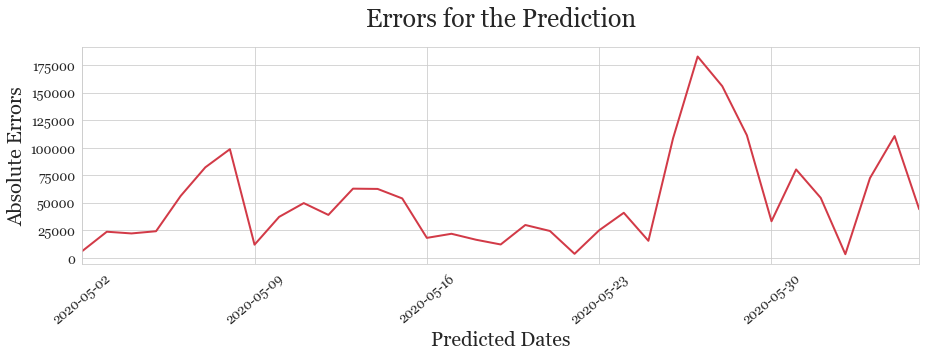

In [109]:
sarimax_run(y=y, n_fourier=6, weather=california_weather['TAVG'].values, window=7, total_predictions=5, plot_graph=True)

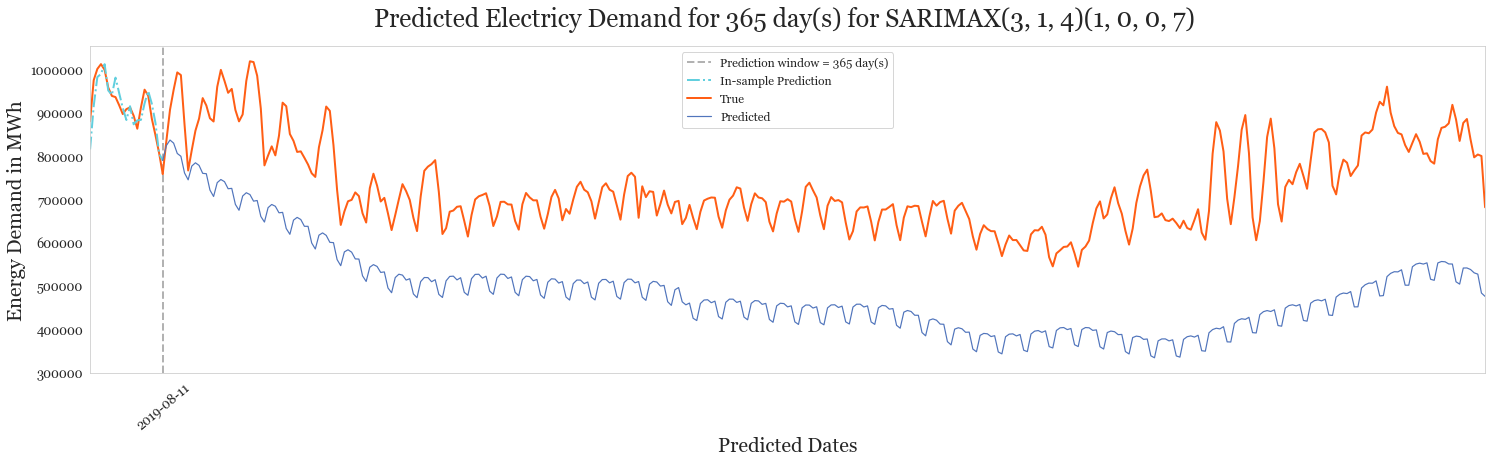

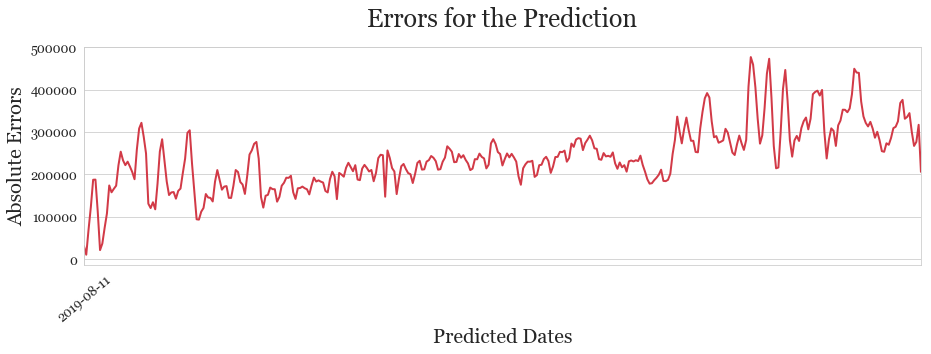

In [115]:
yearly_sarimax_run(y=y, n_fourier=6, window=365, plot_graph=True)

In [ ]:

#get errors for these dates.
days = {1:31,
        2:16,
        3:11,
        4:8,
        5:6,
        6:5,
        7:5}

In [ ]:
from pmdarima.arima import ARIMA

master = {}

y=y
exog=exog

for window, prediction_days in days.items():
    master[window] = {}
    day = window
    true_values = []
    predictions = []
    dates = []
    num_to_update = 0

    for i in range(prediction_days):
        test = len(y) - 100 
        y_to_train = y.iloc[:test]    
        exog_to_train = exog.iloc[:test]

        #first iteration train the model
        if i == 0:
            arima_exog_model = ARIMA(order=(5,1,3), seasonal_order=(2,0,0,7),exogenous=exog_to_train, error_action='ignore',suppress_warnings=True).fit(y=y_to_train)  
           # arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7, error_action='ignore',suppress_warnings=True) 
            preds = arima_exog_model.predict_in_sample(exog_to_train)            
            #first prediction
            y_to_test = y.iloc[test:test+day]
            y_exog_to_test = exog.iloc[test:test+day]
            y_arima_exog_forecast = arima_exog_model.predict(n_periods=day, exogenous=y_exog_to_test)
            true_values.append(y_to_test.values)
            predictions.append(y_arima_exog_forecast.tolist())
            dates.append(y_to_test.index)
           
        
        else:
            y_to_update = y.iloc[test+num_to_update:test+num_to_update+day]
            exog_to_update = exog.iloc[test+num_to_update:test+num_to_update+day]

            #to test
            to_test = y.iloc[test+num_to_update+day:test+num_to_update+(day*2)]
            exog_to_test = exog.iloc[test+num_to_update+day:test+num_to_update+(day*2)]
            #update the model

            arima_exog_model.update(y_to_update,exogenous=exog_to_update)
            y_arima_exog_forecast = arima_exog_model.predict(n_periods=day, exogenous=exog_to_test)
            dates.append(to_test.index)
            predictions.append(y_arima_exog_forecast.tolist())    
            true_values.append(to_test.values)
            num_to_update += day

    dates = [item for sublist in dates for item in sublist]


    predict =  [item for sublist in predictions for item in sublist]
    true = [item for sublist in true_values for item in sublist]
    forecast_errors = [np.abs(true[i]-predict[i]) for i in range(len(predict))]
    
    master[window]['true'] = true
    master[window]['predict'] = predict
    master[window]['insample'] = preds
    master[window]['forecast_errors'] = forecast_errors
    master[window]['dates'] = dates

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
plt.plot(master[1]['dates'], master[1]['forecast_errors'])
plt.plot(master[2]['dates'], master[2]['forecast_errors'])
plt.plot(master[3]['dates'], master[3]['forecast_errors'])
plt.plot(master[4]['dates'], master[4]['forecast_errors'])
plt.plot(master[5]['dates'], master[5]['forecast_errors'])


In [ ]:
master[1]['forecast_error']